# Multiple Linear Regression for Robot Calibration

In this lab, we will illustrate the use of multiple linear regression for calibrating robot control.  In addition to reviewing the concepts in the multiple linear regression demo `demo_diabetes.ipynb`, you will see how to use multiple linear regression for time series data -- an important concept in dynamical systems such as robotics.

The robot data for the lab is taken generously from the TU Dortmund's [Multiple Link Robot Arms Project](https://rst.etit.tu-dortmund.de/en/forschung/robotik/leichtbau/details-tudor/).  As part of the project, they have created an excellent public dataset: [MERIt](https://rst.etit.tu-dortmund.de/en/forschung/robotik/leichtbau/details-tudor/#c11560) -- A Multi-Elastic-Link Robot Identification Dataset that can be used for understanding robot dynamics.  The data is from a three link robot:

<img src="https://rst.etit.tu-dortmund.de/storages/rst-etit/r/Media_Forschung/Robotik/Leichtbau/TUDORBild.png" height="200" width="200">


We will focus on predicting the current **electrical draw** into one of the joint motors as a function of the robot motion. This is just one of many parameters that you might want to build an ML model to predict.  For example, it might be part of a larger system to predict the overall robot power consumption.

## Load and Visualize the Data
First, import the modules we will need.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

The full MERIt dataset can be obtained from the [MERIt site](https://rst.etit.tu-dortmund.de/en/forschung/robotik/leichtbau/details-tudor/#c11560).  But, this dataset is large.  Included in the course repository are two of the ten experiments.  Each experiments corresonds to 80 seconds of recorded motion.  We will use the following files:
* [exp1.csv](https://github.com/cpmusco/machinelearning2022/blob/master/data/exp1.csv) for training
* [exp2.csv](https://github.com/cpmusco/machinelearning2022/blob/master/data/exp2.csv) for test

Below, I have supplied the column headers in the `names` array.  Use the `pd.read_csv` command to load the data. You may wich to refer to the first demo in the class where we used this fucntion. You can load the data directly from the following urls `https://github.com/cpmusco/machinelearning2022/blob/master/data/exp1.csv?raw=true` and `https://github.com/cpmusco/machinelearning2022/blob/master/data/exp2.csv?raw=true`.

In [ ]:
names =[
    't',                                  # Time (secs)
    'q1', 'q2', 'q3',                     # Joint angle   (rads)
    'dq1', 'dq2', 'dq3',                  # Joint velocity (rads/sec)
    'I1', 'I2', 'I3',                     # Motor current (amp)
    'eps21', 'eps22', 'eps31', 'eps32',   # Strain gauge measurements ($\mu$m /m )
    'ddq1', 'ddq2', 'ddq3'                # Joint accelerations (rad/sec^2)
]
# TODO
# dftrain = pd.read_csv(...)
# dftrain = pd.read_csv(...)
url_exp1 = "https://github.com/cpmusco/machinelearning2022/blob/master/data/exp1.csv?raw=true"
url_exp2 = "https://github.com/cpmusco/machinelearning2022/blob/master/data/exp2.csv?raw=true"
df_train = pd.read_csv(url_exp1, names = names)
df_test = pd.read_csv(url_exp2, names = names)

Print the first six lines of the test and train dataframes and manually check that they match the first rows of the csv file.

In [ ]:
# TODO
print(df_train.head(6))
print(df_test.head(6))

      t        q1      q2      q3           dq1            dq2           dq3  \
0  0.00 -0.000007  2.4958 -1.1345 -7.882100e-21 -4.940656e-321  3.913100e-29   
1  0.01 -0.000007  2.4958 -1.1345 -2.258200e-21 -4.940656e-321  2.626200e-31   
2  0.02 -0.000007  2.4958 -1.1345 -6.469800e-22 -4.940656e-321  1.762500e-33   
3  0.03 -0.000007  2.4958 -1.1345 -1.853600e-22 -4.940656e-321  1.182800e-35   
4  0.04 -0.000007  2.4958 -1.1345 -5.310600e-23 -4.940656e-321 -5.270900e-03   
5  0.05 -0.000007  2.4958 -1.1345 -1.521500e-23 -4.940656e-321  3.252600e-04   

         I1       I2       I3   eps21   eps22   eps31    eps32          ddq1  \
0 -0.081623 -0.40812 -0.30609 -269.25 -113.20  3.5918  1.57860 -9.904900e-19   
1 -0.037411 -0.37241 -0.26698 -270.91 -116.05  1.4585 -1.73980  4.248100e-19   
2 -0.066319 -0.40302 -0.31459 -269.25 -112.97  3.5918  0.86753  3.233800e-19   
3 -0.068020 -0.43703 -0.28398 -269.97 -114.39  1.6956 -0.08059  1.500500e-19   
4 -0.052715 -0.40472 -0.30779 -269.97 -

From the dataframe `dftrain`, extract the time values into a vector `t` and extract `I2`, the electrical current into the second joint. Place the electrical current in a vector `ytrain` and plot `ytrain` vs. `t`.   Label the axes with the units.

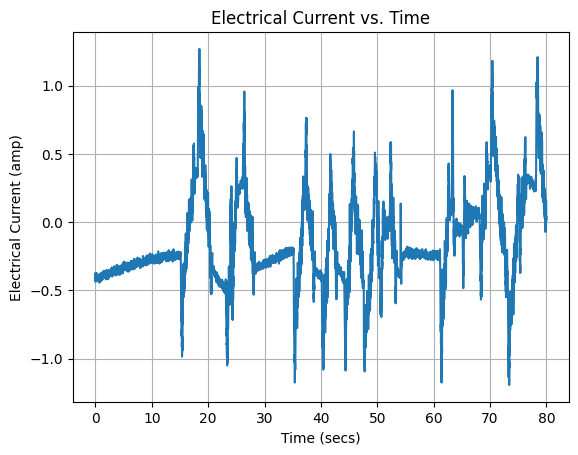

In [ ]:
# TODO
# ytrain = ...
# t = ...
# plt.plot(...)
ytrain = df_train['I2']
t = df_train['t']
plt.plot(t, ytrain)
plt.xlabel('Time (secs)')
plt.ylabel('Electrical Current (amp)')
plt.title('Electrical Current vs. Time')
plt.grid(True)
plt.show()

Use all the samples from the experiment 1 dataset to create the training data:
* `ytrain`:  A vector of all the samples from the `I2` column
* `Xtrain`:  A matrix of the data with the columns:  `['q2','dq2','eps21', 'eps22', 'eps31', 'eps32','ddq2']`

In [ ]:
# TODO
# Xtrain = ...
X_train = df_train[['q2', 'dq2', 'eps21', 'eps22', 'eps31', 'eps32', 'ddq2']]

In [ ]:
print(ytrain.shape)
print(X_train.shape)

(8000,)
(8000, 7)


## Fit a Linear Model
Write an function that, fits a linear model given a predictor matrix `X` and a vector of target values `y`. Your linear model should have an intercept. So, for our robot data, which has 7 predictor variables, the output should be a vector `beta` of length 8. The first entry should be the intercept, $\beta_0$. **Hint**: You might want to use numpy's `concatenate` function and the `ones` function.

Your function should find the optimal `beta` to minimize the squared loss. You should do so using the matrix equations discussed in class -- do not use any built in functions from e.g. Scikit Learn.

In [ ]:
def fit_mult_linear(X,y):
    """
    Given matrix of predictors X and target vector y fit for a multiple linear regression model under the squared loss.
    """
    # TODO complete the following code
    # beta = ...
    X_with_intercept = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

    # Calculate the pseudo-inverse of the design matrix
    X_pinv = np.linalg.pinv(X_with_intercept)
    print(X_pinv.shape)
    print(y.shape)
    # Solve for the model coefficients
    beta = X_pinv.dot(y)
    print(beta.shape)

    return beta

Train the model on the training data.

In [ ]:
# TODO
beta = fit_mult_linear(X_train,ytrain)
print(beta)
print(beta.shape)

(8, 8000)
(8000,)
(8,)
[-0.08408084  0.06255018  0.20584896  0.00118784  0.00044457 -0.0031362
  0.00603298  0.05487097]
(8,)


Using the trained model, compute `ytrain_pred`, the predicted current.  Plot `ytrain_pred` vs. time `t`.  On the same plot, plot the actual current `ytrain` vs. time `t`.  Create a legend for the plot.

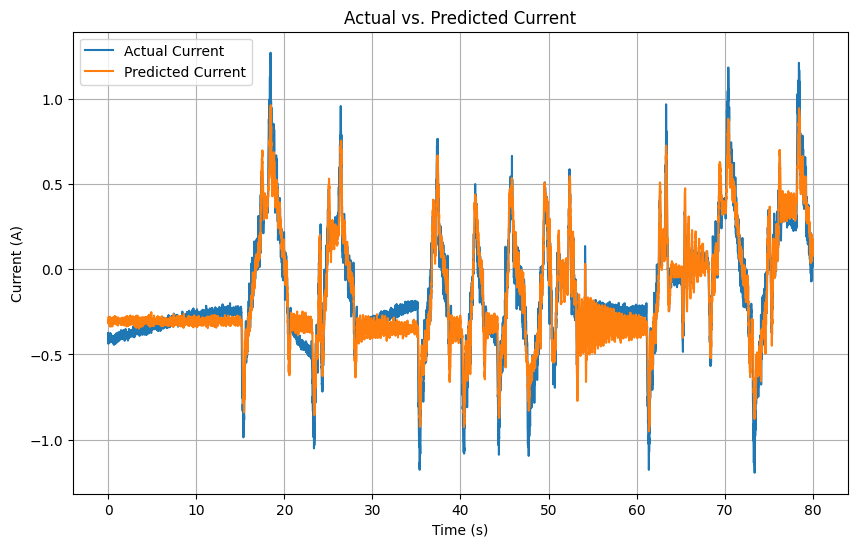

In [ ]:
# TODO
# ytrain_pred = ...
# plt.plot(...)
# Calculate predicted current
X_with_intercept = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1)
ytrain_pred = np.dot(X_with_intercept,beta)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(t, ytrain, label='Actual Current')
plt.plot(t, ytrain_pred, label='Predicted Current')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('Actual vs. Predicted Current')
plt.legend()
plt.grid(True)
plt.show()


## Measure the Fit on an Indepedent Dataset

Up to now, we have only tested the model on the same data on which it was trained.  In general, we need to test models on independent data to truly understand the models quality -- otherwise, we might overfit.  For this purpose, consider the data loaded from `exp2.csv`.  Compute the regression predicted values on this data and plot the predicted and actual values over time.

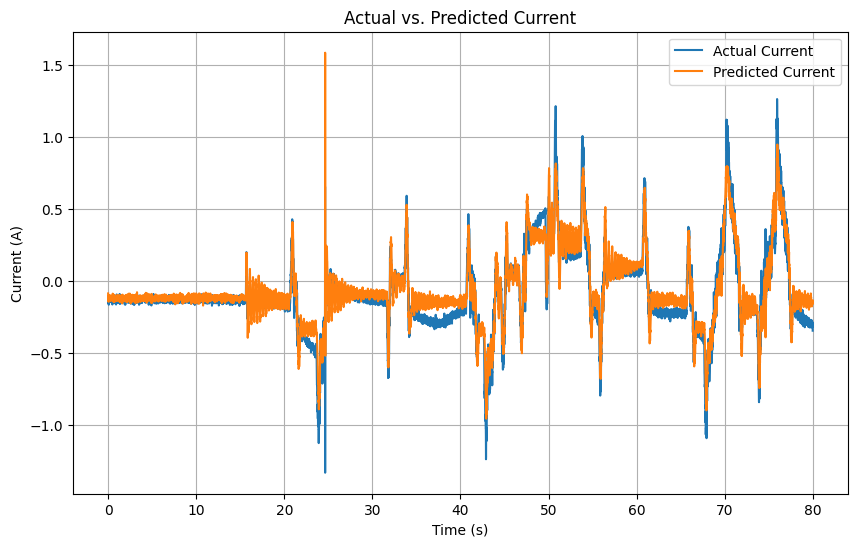

In [ ]:
# TODO
X_test = df_test[['q2', 'dq2', 'eps21', 'eps22', 'eps31', 'eps32', 'ddq2']]
X_test_with_intercept = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)

ytest_pred = np.dot(X_test_with_intercept,beta)
ytest = df_test['I2']
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(t, ytest, label='Actual Current')
plt.plot(t, ytest_pred, label='Predicted Current')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('Actual vs. Predicted Current')
plt.legend()
plt.grid(True)
plt.show()